# Feed Forward Spiking Neural Network
### Building Neuromorphic Computing Models using snnTorch

* Making a leaky integrate-and-fire (LIF) neuron (compatible with deep learning)
* Implementing a feedforward spiking neural network (SNN)

In [1]:
# imports
import snntorch as snn
from snntorch import spikeplot as splt
from snntorch import spikegen

import torch
import torch.nn as nn
import matplotlib.pyplot as plt

### Plotting Settings

In [2]:
#@title Plotting Settings
def plot_cur_mem_spk(cur, mem, spk, thr_line=False, 
                     vline=False, title=False, ylim_max1=1.25, ylim_max2=1.25):
    # Generate plots
    fig, ax = plt.subplots(3, figsize=(8, 6), sharex=True,
                          gridspec_kw={'height_ratios': [1, 1, 0.4]})
    
    # Plot input current
    ax[0].plot(cur, c='tab:orange')
    ax[0].set_ylim([0, ylim_max1])
    ax[0].set_xlim([0, 200])
    ax[0].set_ylabel("Input Current ($I_{in})")
    if title:
        ax[0].set_title(title)
        
    # Plot membrane potential
    ax[1].plot(mem)
    ax[1].set_ylim([0, ylim_max2])
    ax[1].set_ylabel("Membrane Potential (${U_{mem}})")
    if thr_line:
        ax[1].axhline(y=thr_line, alpha=0.25, linestyle="dashed", c="black",
                     linewidth=2)
    plt.xlabel("Time step")
    
    # Plot output spike using spikeplot
    splt.raster(spk, ax[2], s=400, c="black", marker="|")
    if vline:
        ax[2].axvline(x=vline, ymin=0, ymax=6.75, alpha=0.15, linestyle="dashed",
                     c="black", linewidth=2, zorder=0, clip_on=False)
        
    plt.ylabel("Output Spikes")
    plt.yticks([])
    
    plt.show()
    
    
def plot_snn_spikes(spk_in, spk1_rec, spk2_rec, title):
    # Generate Plots
    fig, ax = plt.subplots(3, figsize=(8, 7), sharex=True,
                          gridspec_kw={"height_ratios": [1, 1, 0.4]})
    
    # Plot input spikes
    splt.raster(spk_in[:, 0], ax[0], s=0.03, c="black")
    ax[0].set_ylabel("Input Spikes")
    ax[0].set_title(title)
    
    # Plot hidden layer spikes
    splt.raster(spk1_rec.reshape(num_steps, -1), ax[1], s=0.05, c="black")
    ax[1].set_ylabel("Hidden Layer")
    
    # Plot output layer
    splt.raster(spk1_rec.reshape(num_steps, -1), ax[2], c="black", marker="|")
    ax[2].set_ylabel("Output Spikes")
    ax[2].set_ylim([0, 10])
    
    plt.show()
    

# 1. Simple LIF Neuron Model

Using Euler method we get:
$$ U(t+\Delta t) = (1 - \frac{\Delta t}{\tau}) U(t) + \frac{\Delta t}{\tau} I_{in}(t) R $$
and for $I_{in}(t) = 0 A:~~~~~~~~~~~~~~~~ U (t + \Delta t) = (1 - \frac{\Delta t}{\tau} U(t)$


In discrete time steps $(\Delta t = 1)$:

taking $\beta = U[t+1]\ /\ U[t]\ \ $ and $\ \ W\ X[t+1] = I_{in}[t]\ \ $\
we get:
$$ U[t+1] = \beta~U[t] + WX[t+1] $$

$\beta$ become a hyper-parameter whereas, $W$ is a learnable parameter that is updated independently of $\beta$

### 1.1 Spiking and Reset
If the membrane potential exceeds the threshold, then the neuron emits an output spike:
$$ S[t] = \begin{cases} 1, &\text{if}~U[t] > U_{\rm thr} \\
                        0, &\text{otherwise}\end{cases} $$
                       
                       
If a spike is triggered, the membrane potential should be reset. The reset-by-subtraction mechanism is modeled by:
$$ U[t+1] = \underbrace{\beta~U[t]}_\text{decay} + \underbrace{W~X[t+1]}_\text{input} - \underbrace{S[t]~U_{thr}}_\text{reset} $$



Since $\beta = U[t+1]~/~U[t]$ and $U(t) = U_0\ e^{-\frac{t}{\tau}},\ \beta = e^{-\frac{\Delta t}{\tau}}$

### 1.2 Code Implementation
neuron implementation in python

In [3]:
def leaky_integrate_and_fire(mem, x, w, beta, threshold=1):
    spk = (mem > threshold)
    mem = beta*mem + w*x - spk*threshold
    return spk, mem

In [4]:
# set neuron parameters
delta_t = torch.tensor(1e-3)
tau = torch.tensor(5e-3)
beta = torch.exp(-delta_t/tau)

print(f'The decay rate is: {beta:.3f}')

The decay rate is: 0.819


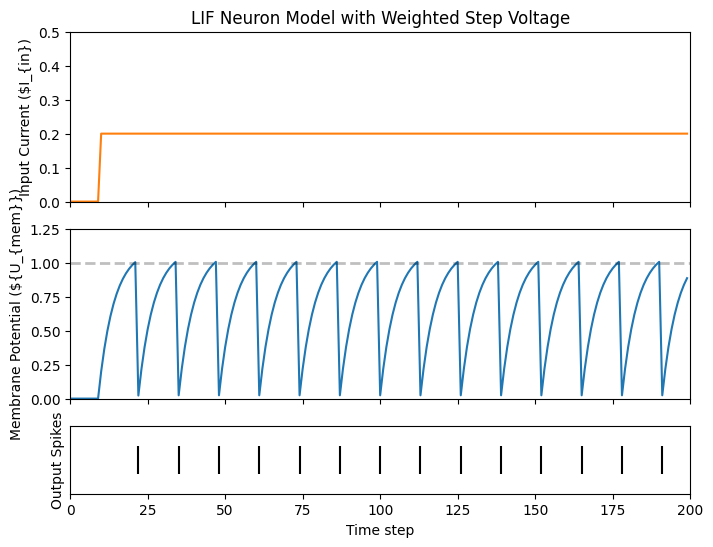

In [5]:
# Quick simulation run for "Step" Voltage
num_steps = 200

# initialize inputs/outputs + small step current input
x = torch.cat((torch.zeros(10), torch.ones(190)*0.5), 0)
mem = torch.zeros(1)
spk_out = torch.zeros(1)
mem_rec, spk_rec = [], []

# neuron parameters
w = 0.4
beta = 0.819

# neuron simulation
for step in range(num_steps):
    spk, mem = leaky_integrate_and_fire(mem, x[step], w, beta)
    mem_rec.append(mem)
    spk_rec.append(spk)
    
# convert lists to tensors
mem_rec = torch.stack(mem_rec)
spk_rec = torch.stack(spk_rec)

plot_cur_mem_spk(x*w, mem_rec, spk_rec, thr_line=1, ylim_max1=0.5,
                title="LIF Neuron Model with Weighted Step Voltage")

# 2. `Leaky` Neuron Model in snnTorch

**Inputs**
* `cur_in`: each element of W x X[t] is sequentially passed as an input
* `mem`: the previous step membrane potential, U[t-1] is also passes as an input

**Outputs**
* `spk_out`: output spike S[t]
* `mem`: membrane potential U[t] at present step

Note: all inputs and outputs are of type `torch.Tensor`.
Assumed that input current has already been weighted before passing into the `snn.Leaky` neuron, helpful for network-scale model.

In [6]:
lif1 = snn.Leaky(beta=0.8)

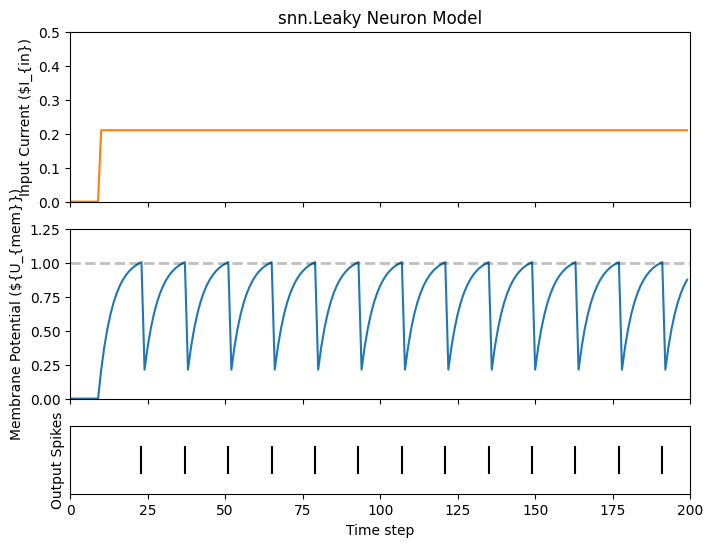

In [7]:
# Small step current input
w = 0.21
cur_in = torch.cat((torch.zeros(10), torch.ones(190)*w), 0)
mem = torch.zeros(1)
spk = torch.zeros(1)
mem_rec, spk_rec = [], []

# neuron simulation
for step in range(num_steps):
    spk, mem = lif1(cur_in[step], mem)
    mem_rec.append(mem)
    spk_rec.append(spk)
    
# Convert lists to tensor
mem_rec = torch.stack(mem_rec)
spk_rec = torch.stack(spk_rec)

plot_cur_mem_spk(cur_in, mem_rec, spk_rec, thr_line=1, ylim_max1=0.5, title="snn.Leaky Neuron Model")

Notice that the membrane potential doesn't relax to 0 immediately.

snnTorch uses ***soft reset***: $U[t+1] = \underbrace{\beta\ U[t]}_\text{decay} + \underbrace{W\ X[t+1]}_\text{input} - \underbrace{\beta\ S[t]\ U_{thr}}_\text{soft reset} $

This model has optional input arguments of `reset_mechanism` and `threshold`.

# 3. Feed-forward Spiking Neural Network

Using snnTorch, we can expand the models we're building to a deep neural network.

We're creating a 3-layer fully connected neural network of dimensions 784 x 1000 x 10
<!-- ![image.png](attachment:image.png) -->

<img src="3-layer Spiking NN.png" width=600 />


PyTorch is used to form the connections between neurons, and snnTorch to create the neurons.

In [8]:
# First, initialize all layers

# layer inputs
num_inputs = 784
num_hidden = 1000
num_outputs = 10
beta = 0.99

# initialize layers
fc1 = nn.Linear(num_inputs, num_hidden)
lif1 = snn.Leaky(beta)
fc2 = nn.Linear(num_hidden, num_outputs)
lif2 = snn.Leaky(beta)


In [9]:
# Next, initialize the hidden variables & outputs of each spikign neuron

# initialize hidden states
torch.manual_seed(0)
mem1 = lif1.init_leaky()
mem2 = lif2.init_leaky()

# record outputs
mem2_rec = []
spk1_rec, spk2_rec = [], []


Create an input spike train to pass to the network. There are 200 time steps to simulate across 784 input neurons, i.e.., the input originally has dimensions of 200 x 784. However, neural nets typically process data in mini-batches. snnTorch uses time-first dimensionality:

[time x batch x feature_dimensions]

So `unsqueeze` the input along `dim=1` to indicate 'one batch' of data. The dimensions of this input tensor must be 200 x 1 x 784

In [10]:
spk_in = spikegen.rate_conv(torch.rand((200, 784))).unsqueeze(1)
print(f"Dimensions of spk_in: {spk_in.shape}")

Dimensions of spk_in: torch.Size([200, 1, 784])


**Intuition:** PyTorch routes the neurons together, and snnTorch loads the results into spiking neuron models.

In terms of coding up a network, these spiking neurons can be treated like time-varying activation functions.

Here is a sequential account of what's going on:
* The %i^{th}% input from `spk_in` to the $j_{th}$ neuron is weighted by the parameters initialized in `nn.Linear`: $X_i$ x $W_{ij} $\
This generates the input current term
* If $U[t+1] > U_{thr}$, then a spike is triggered from this neuron\
This spike is weighted by the second layer weight, and above process is repeated for all inputs, weights, and neurons.
* If no spike is generated, then nothing is passed to the post-synaptic neuron.


The only difference from our simulations thus far is tat we are now scaling the input current with a weight generated by `nn.Linear`, rather than manually settign $W$ ourselves.

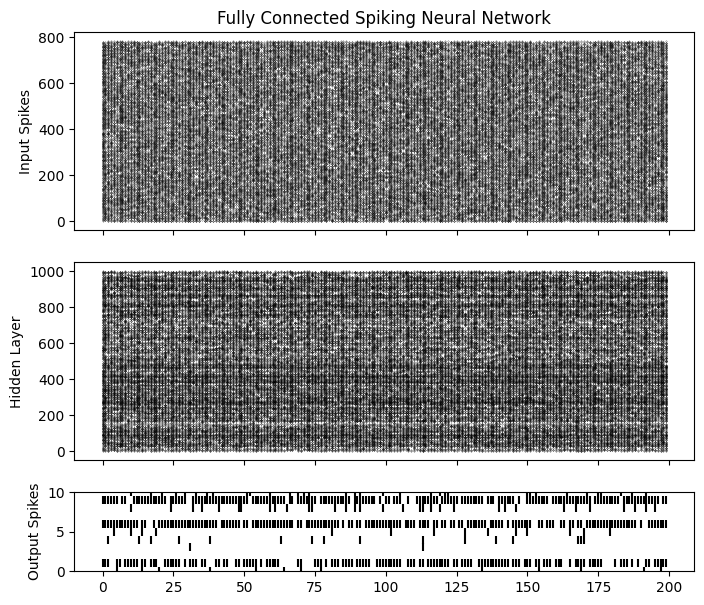

In [11]:
# network simulation
for step in range(num_steps):
    cur1 = fc1(spk_in[step])      # post-synaptic current <-- spk_in x weight
    spk1, mem1 = lif1(cur1, mem)  # mem[t+1] <-- post-syn current + decay
    cur2 = fc2(spk1)
    spk2, mem2 = lif2(cur2, mem2)
    
    mem2_rec.append(mem2)
    spk1_rec.append(spk1)
    spk2_rec.append(spk2)
    
# convert lists to tensors
mem2_rec = torch.stack(mem2_rec)
spk1_rec = torch.stack(spk1_rec)
spk2_rec = torch.stack(spk2_rec)


plot_snn_spikes(spk_in, spk1_rec, spk2_rec, "Fully Connected Spiking Neural Network")

> `spikeplot.spike_count` can create a spike counter of the output layer. 


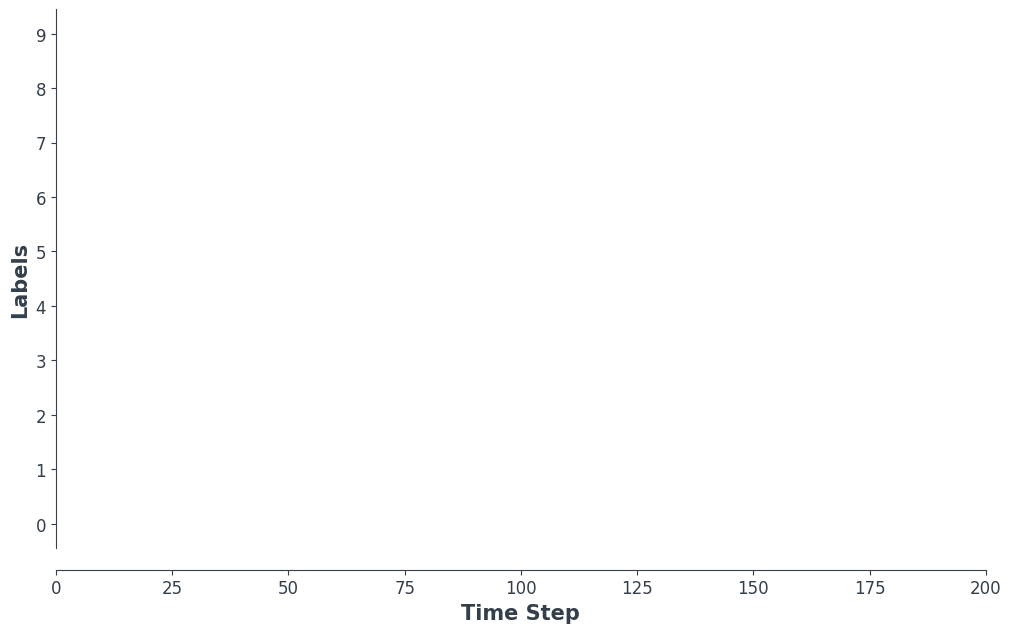

In [13]:
# The following animation willl take some time to generate
from IPython.display import HTML

fig, ax = plt.subplots(facecolor='w', figsize=(12, 7))
labels = [str(x) for x in range(10)]
spk2_rec = spk2_rec.squeeze(1).detach().cpu()

anim = splt.spike_count(spk2_rec, fig, ax, labels=labels, animate=True)
HTML(anim.to_html5_video())
anim.save("spike_bar.mp4")

`spikeplot.traces`: visualize the membrane potential traces.

Below 9 out of 10 output neuron membrane potential traces are plotted.
Is it a match between animation, raster plot & the membrane potential trace plots? 

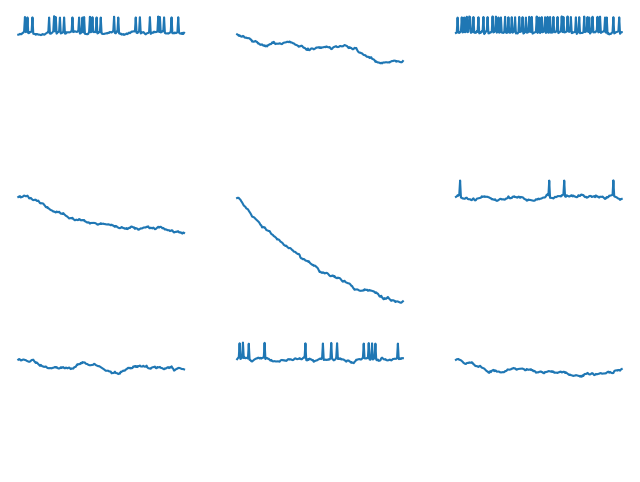

In [16]:
# plot membrane potential traces
splt.traces(mem2_rec.squeeze(1), spk=spk2_rec.squeeze(1))
fig = plt.gcf()
fig.set_size_inches(8, 6)

Based on the tutorials by Jason K. Eshraghian: [Github](https://github.com/snntorch/Spiking-Neural-Networks-Tutorials?tab=readme-ov-file)

Documentation can be found here: [Documentation](https://snntorch.readthedocs.io/en/latest/snntorch.html )